# The Street View House Numbers (SVHN) Dataset

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images. The dataset and more information can be founded [`here`](http://ufldl.stanford.edu/housenumbers/).

## Loading data and libraries

In [1]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 294kB/s ta 0:00:01


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from urllib.request import urlretrieve
from os.path import isfile
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

%matplotlib inline
tf.reset_default_graph()

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train_32x32.mat'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Dataset') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            'train_32x32.mat',
            pbar.hook)

svhn_data = loadmat('train_32x32.mat')
print('Data loaded!')

SVHN Dataset: 182MB [00:44, 4.10MB/s]                               


Data loaded!


## Understanding the dataset

In [3]:
print(type(svhn_data))
print(svhn_data.keys())

<class 'dict'>
dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [4]:
features = svhn_data['X']
labels = svhn_data['y']

print('X: {} ({} x {} x {}) images'.format(features.shape[3], features.shape[0],
                                           features.shape[1], features.shape[2]))
print('y: {} ({}) labels'.format(labels.shape[0], labels.shape[1]))
print('First 30 labels: {}'.format(labels[:30].reshape((1,-1))))
print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

X: 73257 (32 x 32 x 3) images
y: 73257 (1) labels
First 30 labels: [[1 9 2 3 2 5 9 3 3 1 3 3 2 8 7 4 4 1 2 8 1 6 2 3 6 3 4 2 5 8]]
Label Counts: {1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 9: 4659, 10: 4948}


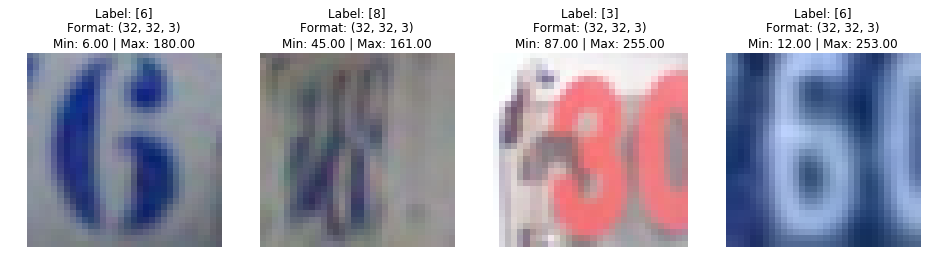

In [5]:
def display_sample_images(features, labels, n, normalized=False):
    fig = plt.figure(figsize=(16, 16))
    for i in range(n):
        plt.subplot(1,n,i + 1)
        image_num = np.random.randint(0, high=73257)
        if normalized:
            image_num = np.random.randint(0, high=len(features))
            sample_image = features[image_num]
        else:
            sample_image = features[:,:,:,image_num]
        sample_label = labels[image_num]
        plt.axis('off')
        plt.title('Label: {}\nFormat: {}\nMin: {:.2f} | Max: {:.2f}'.format(sample_label,
                                                                    sample_image.shape,
                                                                    sample_image.min(),
                                                                    sample_image.max()))
        plt.imshow(sample_image)
    plt.show()

display_sample_images(features, labels, 4)

## Preprocessing

### Normalize

In [6]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    n = x.shape[3]
    result = []
    for i in range(n):
        result.append(x[:,:,:,i] / 255.0)
    return np.array(result)

features = normalize(features)
features.shape

(73257, 32, 32, 3)

### One-hot encode

In [7]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    result = []
    for i in range(len(x)):
        result.append([1 if x[i] == j + 1 else 0 for j in range(10)])
    return np.array(result)

labels = one_hot_encode(labels)
labels.shape

(73257, 10)

### Split train and test set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=0)

print('Train features: {}, train labels: {}'.format(X_train.shape, y_train.shape))
print('Test features: {}, test labels: {}'.format(X_test.shape, y_test.shape))

Train features: (54942, 32, 32, 3), train labels: (54942, 10)
Test features: (18315, 32, 32, 3), test labels: (18315, 10)


### Sanity check


Train set:


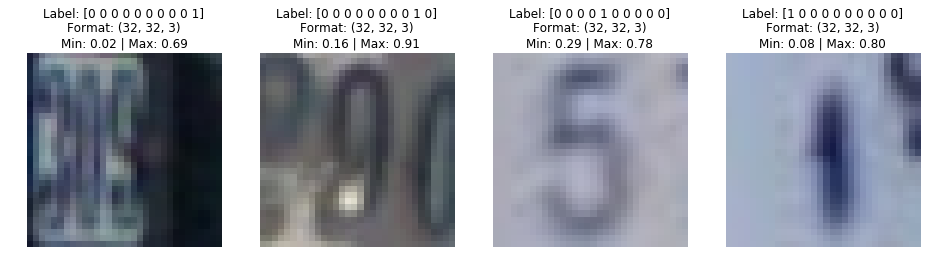


Test set:


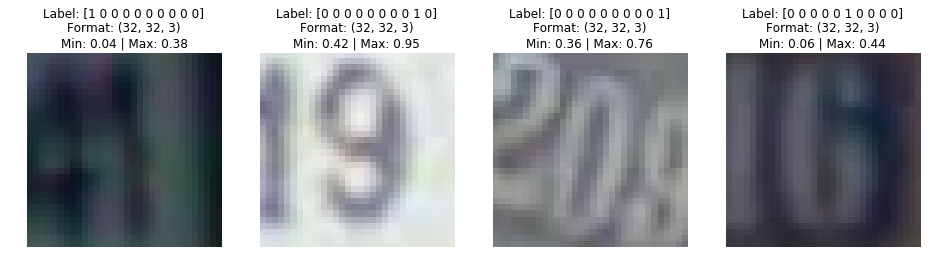

In [9]:
print('\nTrain set:')
display_sample_images(X_train, y_train, 4, normalized=True)

print('\nTest set:')
display_sample_images(X_test, y_test, 4, normalized=True)

## Building the Neural Net

### Building nodes, weights, biases

In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, scope='conv'):
    
    with tf.variable_scope(scope):
        # Dimension parameters
        input_depth    = x_tensor.get_shape().as_list()[3]
        conv_height    = conv_ksize[0]
        conv_width     = conv_ksize[1]
        strides_height = conv_strides[0]
        strides_width  = conv_strides[1]
        padding        = 'SAME'
        
        # Initiate weights and biases
        W = tf.Variable(tf.random_normal([conv_height, conv_width, input_depth, conv_num_outputs], stddev=0.1))
        b = tf.Variable(tf.random_normal([conv_num_outputs], stddev=0.1))
        
        # Draw convnet
        output = tf.nn.conv2d(x_tensor, W, [1, strides_height, strides_width, 1], padding)
        output = tf.nn.bias_add(output, b)
        output = tf.nn.relu(output)
        
        # Max pool parameters
        pool_height    = pool_ksize[0]
        pool_width     = pool_ksize[1]
        pool_strides_h = pool_strides[0]
        pool_strides_w = pool_strides[1]
        
        # Maxpool
        output = tf.nn.max_pool(output,
                                ksize=[1, pool_height, pool_width, 1],
                                strides=[1, pool_strides_h, pool_strides_w, 1],
                                padding=padding)
        
        return output

In [11]:
def flatten(x_tensor, scope='flat'):
    
    with tf.variable_scope(scope):
        height = x_tensor.get_shape().as_list()[1]
        width  = x_tensor.get_shape().as_list()[2]
        depth  = x_tensor.get_shape().as_list()[3]
        return tf.reshape(x_tensor,[-1, height * width * depth])

In [12]:
def fully_conn(x_tensor, num_outputs, keep_prob=None, scope='fc'):
    
    with tf.variable_scope(scope):
        W = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs], stddev=0.1))
        b = tf.Variable(tf.zeros([num_outputs]))
        fc = tf.nn.relu(tf.matmul(x_tensor, W) + b)
        if keep_prob is not None:
            fc = tf.nn.dropout(fc, keep_prob)
        return fc

In [13]:
def output(x_tensor, num_outputs, scope='output'):
    with tf.variable_scope(scope):
        W = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs], stddev=0.1))
        b = tf.Variable(tf.zeros([num_outputs]))
        return tf.matmul(x_tensor, W) + b

### Neural Net layout

In [14]:
x = tf.placeholder(tf.float32, (None, features.shape[1], features.shape[2], features.shape[3]), 'x')
y = tf.placeholder(tf.float32, (None, labels.shape[1]), 'y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# 3 layer convnet 
conv = conv2d_maxpool(x,32,(5, 5),(1, 1),(2, 2),(2, 2), scope='conv1')
conv = conv2d_maxpool(conv,64,(3, 3),(1, 1),(2, 2),(2, 2), 'conv2')
conv = conv2d_maxpool(conv,128,(1, 1),(1, 1),(2, 2),(2, 2), 'conv3')

# Fully connected layer
flat = flatten(conv, scope='flat')
fc   = fully_conn(flat, 1024, keep_prob=keep_prob, scope='fc1')

# Logits output
logits = output(fc, labels.shape[1], scope='output')

### Loss and optimizer

In [15]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

### Accuracy

In [17]:
prediction = tf.argmax(logits, 1) + 1
correct_pred = tf.equal(prediction,(tf.argmax(y,1) + 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

## Training the neural net

In [18]:
epochs = 50
batch_size = 1024
val_size = 0.1
train_keep_prob = 0.5
display_step = 10

In [19]:
def batch_creator(features, labels, batch_size, val_size=None):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        if val_size is not None:
            feat_batch_train, feat_batch_val, lab_batch_train, lab_batch_val = train_test_split(features[start:end],
                                                                                                labels[start:end],
                                                                                                test_size=val_size,
                                                                                                random_state=0)
            yield feat_batch_train, feat_batch_val, lab_batch_train, lab_batch_val
        else:
            yield features[start:end], labels[start:end]

In [20]:
init = tf.global_variables_initializer()

train_acc_results = []
val_acc_results = []
images_samples = []
train_acc_mean = 0
val_acc_mean = 0
with tf.Session() as sess:
    sess.run(init)
    iteration = 0
    for epoch in range(epochs):
        for X_batch_train, X_batch_val, y_batch_train, y_batch_val in batch_creator(X_train, y_train, batch_size, val_size):
            train_feed_dict = {x: X_batch_train,
                               y: y_batch_train,
                               keep_prob: train_keep_prob
                              }
            sess.run(optimizer, feed_dict=train_feed_dict)
            loss = sess.run(cost, feed_dict=train_feed_dict)
            train_acc = sess.run(accuracy, feed_dict=train_feed_dict)
            train_acc_mean += train_acc
            train_acc_mean = train_acc_mean / 2
            
            val_feed_dict = {x: X_batch_val,
                             y: y_batch_val,
                             keep_prob: 1.0
                            }
            val_acc = sess.run(accuracy, feed_dict=val_feed_dict)
            val_acc_mean += val_acc
            val_acc_mean = val_acc_mean / 2
            iteration += 1
        train_acc_results.append(train_acc_mean)
        val_acc_results.append(val_acc_mean)
        if epoch % display_step == 0 or epoch + 1 == epochs:
            print('Epoch {:4d}/{:4d}|Batch {:4d} => \
loss:{:10.4f} | train: {:.4f} | val: {:.4f}'.format(epoch, epochs - 1, iteration,
                                                    loss, train_acc_mean, val_acc_mean))
    rand_image = np.random.randint(0, high=len(X_train))
    sample_image = X_train[rand_image]
    plt.axis('off')
    plt.imshow(sample_image)
    plt.title('Sanity Check\nPrediction: {} | True: {}'.format(sess.run(prediction,
                                                                        feed_dict={x:X_train[rand_image].reshape((-1, 32, 32, 3)),
                                                                                   keep_prob:1.0
                                                                                  }),
                                                               np.where(y_train[rand_image] == 1)[0] + 1))
    plt.show()

KeyboardInterrupt: 

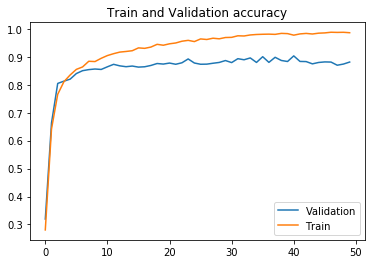

In [25]:
plt.plot(range(len(train_acc_results)), val_acc_results, label='Validation')
plt.plot(range(len(train_acc_results)), train_acc_results, label='Train')
plt.title('Train and Validation accuracy')
plt.legend()
plt.show()